# Training

## Loss function
The loss function is the $L_2$ loss on the prediceted per-particle accelerations. The model parameters are optimizied over the loss using the Adam optimizer, using a minibatch size of 2.


## Noise
Because the models take as input a sequence of states (positions and velocities), we draw independent samples $\sim{N}(0, \sigma_v=0.0003)$, for each input state, particle and spatial dimension, before each training step. We accumulate them across time as a random walk, and use this to perturb the stack of input velocities. Based on the updated velocities, we then adjust the position features, such that $\dot{p}^t\equiv p^t-p^{t-1}$ is maintained, for consistency.


## Normalization
All inputs and targets are normalized to zero mean and unit variance during training. Instead of using moving averages, which could shift in cycles during training, we build exact mean and variance for all of the input and target particle features seen up to the current training step $l$, by accumulating the sum, the sum of the squares and the total particle count. The statistics are computed after noise is applied to the inputs.




In [1]:
#setup
%load_ext autoreload
%cd "/workspace"

/workspace


In [2]:
!pip install livelossplot
!pip install tqdm

     |################################| 19.3 MB 8.1 MB/s eta 0:00:01
     |################################| 269 kB 10.8 MB/s eta 0:00:01
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=0e393dd59476125df28833439698b0ff117021e299bc10d17da3c4aa3fb8ab28
  Stored in directory: /home/user/.cache/pip/wheels/5a/91/69/b72c84a8ba487df5d7d376c4bcedc9077d14b32511069187e7
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=90c65223a1e837321c2db22152013cba7433a7f9bc9814e07ec874430688b4b5
  Stored in directory: /home/user/.cache/pip/wheels/e5/9d/ad/2ee53cf262cba1ffd8afe1487eef788ea3f260b7e6232a80fc
Successfully built bokeh PyYAML
     |################################| 63 kB 910 kB/s eta 0:00:011


In [4]:
%%writefile open_gns/normalizer.py

# Normalizer
import torch

class Normalizer():
    def __init__(self, size, mask_cols=None, device=None):
        self.x_sum = torch.zeros(size)
        self.x_centered_sum2 = torch.zeros(size)
        if device is not None:
            self.x_sum = self.x_sum.to(device)
            self.x_centered_sum2 = self.x_centered_sum2.to(device)
        self.num_particles = 0
        self.mask_cols = mask_cols

    def __call__(self, x):
        self.num_particles += x.size(0)
        self.x_sum += torch.sum(x,0)
        mean = torch.div(self.x_sum, self.num_particles)
        zero_mean = x - mean
        self.x_centered_sum2 += torch.sum(torch.pow(zero_mean, 2), 0)
        var = torch.div(self.x_centered_sum2, self.num_particles) + 1.0e-10
        normalized_x = torch.div(zero_mean, var)
        if self.mask_cols is not None:
            normalized_x[:,self.mask_cols] = x[:, self.mask_cols]
        return normalized_x

Overwriting open_gns/normalizer.py


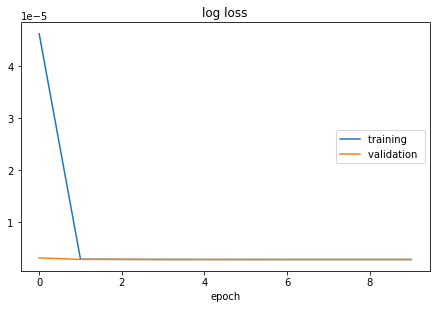

log loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [2]:
%autoreload 2
# Training loop
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import MSELoss
from open_gns.normalizer import Normalizer
from open_gns.models import EncodeProcessDecode
from open_gns.dataset import GNSDataset
from torch_geometric.data import DataLoader
from livelossplot import PlotLosses
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_train = GNSDataset('./notebooks')
dataset_val = GNSDataset('./notebooks', split='validation')
dataloaders = {
    'train': DataLoader(dataset_train, batch_size=2, shuffle=True),
    'validation': DataLoader(dataset_val, batch_size=2, shuffle=False)
}
input_size = dataset_train.num_node_features
model = EncodeProcessDecode(input_size).to(device)

optimizer = Adam(model.parameters(), lr=0.001)
lr_scheduler = ExponentialLR(optimizer,0.4)
mse = MSELoss()
liveloss = PlotLosses()

for epoch in range(10):
    logs = {}
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        running_loss = 0.0
        for i, data in enumerate(tqdm(dataloaders[phase])):
            data = data.to(device)
            y_pred = model(data.x, data.edge_index)
            loss = mse(y_pred, data.y)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            running_loss += loss.item()*data.num_graphs
        # Log epoch loss
        epoch_loss = running_loss/len(dataloaders[phase].dataset)
        label = 'log loss' if phase == 'train' else 'val_log loss'
        logs[label] = epoch_loss
        # Save checkpoint
        if phase == 'train':
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f'checkpoint_{epoch}_{epoch_loss}.pt')
    lr_scheduler.step()
    liveloss.update(logs)
    liveloss.send()
